In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem as Chem
from pathlib import Path
from rdkit.Chem import Descriptors,  RDConfig
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.model_selection import cross_validate
from keras.layers import Dense, Dropout # Activation
from keras.optimizers import SGD
from keras import Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#import glob
import os
import sys
import tensorflow as tf
from tensorflow import keras
from IPython.core.display import HTML
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
import base64
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer as sa
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.scscore.standalone_model_numpy import SCScorer
#from rdkit.Chem.Scaffolds import MurckoScaffold
import keras_tuner as kt
from math import sqrt
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold

In [2]:
from numpy.random import seed
seed(1)

In [3]:
#!pip install keras-tuner

In [4]:
df = pd.read_csv('data/7Mfinal_balanced_bin_filter_scaf.csv')

In [3]:
corr = df[['number_of_steps', 'syba', 'sascore', 'scscore','MolWt','MolLogP','NumHAccept','NumHDonors']].corr()
corr_sm = corr.number_of_steps.abs().nlargest(10).index 
display(corr.number_of_steps.loc[corr_sm])

number_of_steps    1.000000
sascore            0.549571
syba              -0.450635
MolWt              0.356924
scscore            0.289532
NumHAccept         0.271237
NumHDonors         0.151229
MolLogP            0.097490
Name: number_of_steps, dtype: float64

In [5]:
mols = [Chem.MolFromSmiles(m) for m in df.target]
df['mol'] = mols

- removing outliers

In [ ]:
Q1 = df[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors','NumHetero','TPSA']].quantile(0.25)
Q3 = df[['syba', 'sascore', 'scscore', 'MolWt', 'MolLogP', 'NumHAccept', 'NumHDonors','NumHetero','TPSA']].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
df_drop_out = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df.shape, df_drop_out.shape #((21537, 12)

In [ ]:
df = df_drop_out

# Neural Network

Visualization function taken from the article https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0

In [6]:
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color  
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

In [205]:
def print_metrics(history):   
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4)) #sharey=True, 
    ax[0].set(title="MSE") 
    ax[0].plot(history.history['loss'], color='black')    
    ax[0].set_xlabel('Epochs')    
    ax[0].set_ylabel('MSE', color='black')  
    ax[0].plot(history.history['val_loss'], color='blue')
    ax[1].set(title="MAE") 
    ax[1].plot(history.history['mae'], color='black')    
    ax[1].set_xlabel('Epochs')    
    ax[1].set_ylabel('MAE', color='black')  
    ax[1].plot(history.history['val_mae'], color='blue')
    
def evaluate_nn(keras_model, X_train, y_train, X_test, y_test):
    print("Evaluate")
    res_train = keras_model.evaluate(X_train, y_train)
    res_test = keras_model.evaluate(X_test, y_test)
    print("\nTrain data")
    display(dict(zip(keras_model.metrics_names, res_train)))
    print("Test data")
    display(dict(zip(keras_model.metrics_names, res_test)))
    
def test_evaluate(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    return model.evaluate(x_test, y_test)

def cross_scoring(model, X, Y):
    cv = RepeatedKFold(n_splits=10, n_repeats=30, random_state=1)
    score = {'r2':'r2',
         'MAE':'neg_mean_absolute_error',
         'MSE':'neg_mean_squared_error',
         'RMSE':'neg_root_mean_squared_error'}
    scores = cross_validate(model, X, Y, scoring=score, cv=cv)
    return scores

def return_round_predict(model, X_train, y_train, X_test, limit):
    model_fit = model.fit(X_train, y_train)
    predict = model_fit.predict(X_test)
    predict_r = np.array([round(y) for y in predict])
    for i in range(len(predict_r)):
        if predict_r[i] > limit:
            predict_r[i] = limit
    return predict_r  

In [179]:
RFR = RandomForestRegressor(random_state=0)
XGB = xgb.XGBRegressor()
SV = SVR()
KNR = KNeighborsRegressor()
MLP = MLPRegressor(random_state=0, max_iter=1000)

## Prediction of four groups

In [9]:
y = np.array(df.steps_bins).ravel()
x = np.array(df[['syba', 'sascore', 'scscore','MolWt','MolLogP','NumHAccept','NumHDonors']])
x = StandardScaler().fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

Try the optimal parameter settings.

In [293]:
def model_builder(hp):
    hp_units = hp.Int('units', min_value=4, max_value=28, step=4)
    hp_units2 = hp.Int('units2', min_value=4, max_value=28, step=4)
    hp_rate = hp.Choice('rate', values=[0.01, 0.1, 0.2, 0.4, 0.6, 0.8])
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])
    hp_activation = hp.Choice('activation', values=['sigmoid','relu','softmax','tanh','elu'])
    hp_activation2 = hp.Choice('activation2', values=['sigmoid','relu','softmax','tanh','elu'])
    hp_activation3 = hp.Choice('activation3', values=['sigmoid','relu','softmax','tanh','elu','linear'])
    model = Sequential()
    model.add(Input(x.shape[1]))
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
    model.add(Dropout(rate=hp_rate))
    model.add(keras.layers.Dense(units=hp_units2, activation=hp_activation2))
    model.add(Dense(1, activation=hp_activation3))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_squared_error', metrics='mae')
    return model

In [294]:
tuner = kt.Hyperband(model_builder,objective='val_loss', max_epochs=100, factor=3, 
                     directory='my_dir3',project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [295]:
tuner.search(X_train, y_train, epochs=100, validation_split=0.3, callbacks=[stop_early], batch_size=32)
best_hps = tuner.get_best_hyperparameters()[0]
print("\nThe hyperparameter search is complete.")
print(f"""The optimal number of units: {best_hps.get('units')} """)
print(f"""The optimal number of units 2: {best_hps.get('units2')} """)
print(f"""The optimal number of rate: {best_hps.get('rate')} """)
print(f"""The optimal 1 activation func: {best_hps.get('activation')}""")
print(f"""The optimal 2 activation func: {best_hps.get('activation2')}""")
print(f"""The optimal 3 activation func: {best_hps.get('activation3')}""")
print(f"""The optimal learning rate: {best_hps.get('learning_rate')}""")

Trial 254 Complete [00h 00m 25s]
val_loss: 0.6482604742050171

Best val_loss So Far: 0.6370031833648682
Total elapsed time: 00h 23m 21s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units: 24 
The optimal number of units 2: 8 
The optimal number of rate: 0.1 
The optimal 1 activation func: softmax
The optimal 2 activation func: softmax
The optimal 3 activation func: elu
The optimal learning rate: 0.01


In [296]:
def build_model_groups():
    model = Sequential()
    model.add(Input(x.shape[1]))
    model.add(Dense(24, activation='softmax')) 
    model.add(Dropout(rate=0.1))
    model.add(Dense(8, activation='softmax'))  
    model.add(Dense(1, activation='elu'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics='mae')
    return model

Try the optimal number of epochs. 

In [297]:
#keras_model = tuner.hypermodel.build(best_hps)
keras_model = build_model_groups()
history = keras_model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.3, batch_size=32)

In [298]:
loss_per_epoch = history.history['val_loss']
best_epoch = loss_per_epoch.index(min(loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 31


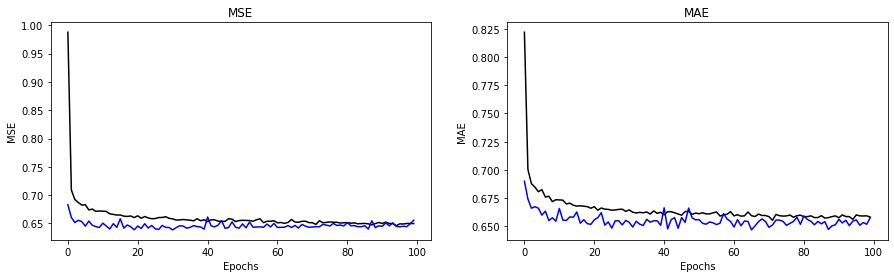

In [299]:
print_metrics(history)

In [300]:
keras_model = build_model_groups()
history = keras_model.fit(X_train, y_train, epochs=31, verbose=0, batch_size=32)

In [301]:
evaluate_nn(keras_model, X_train, y_train, X_test, y_test)

Evaluate
142/142 [==============================] - 0s 832us/step - loss: 0.6681 - mae: 0.6690

Train data


{'loss': 0.652884840965271, 'mae': 0.6594907641410828}

Test data


{'loss': 0.6681178212165833, 'mae': 0.6689777374267578}

In [302]:
kFold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True) #random_state=1, shuffle=True
scores = []
n_repeats=30
for i in range(n_repeats):
    for train, test in kFold.split(x, y):
        model = build_model_groups()
        scores.append(test_evaluate(model, x[train], y[train], x[test], y[test]))

57/57 [==============================] - 0s 1ms/step - loss: 0.6819 - mae: 0.6823


57/57 [==============================] - 0s 1ms/step - loss: 0.6680 - mae: 0.6765


57/57 [==============================] - 0s 2ms/step - loss: 0.6670 - mae: 0.6792


57/57 [==============================] - 0s 1ms/step - loss: 0.6569 - mae: 0.6785


In [303]:
display(dict(zip(keras_model.metrics_names, scores[1])))

{'loss': 0.664278507232666, 'mae': 0.6785871386528015}

In [304]:
d5 = pd.DataFrame.from_dict(scores)
d5 = d5.rename(columns={0:'test_MSE',1:'test_MAE'})
d5['test_MSE'] = -1*d5['test_MSE']
d5['test_MAE'] = -1*d5['test_MAE']
d5['model']='MLP keras'

In [305]:
d5['test_MSE'].mean() 
# Dropout -0.6764872177441915
# -0.6723641214768091
#0.6814346357186636

-0.6795170327027639

In [204]:
RFR_opt = RandomForestRegressor(random_state=0, max_depth=8, n_estimators=400)
XGB_opt = xgb.XGBRegressor(seed=0, learning_rate=0.1, max_depth=6, n_estimators=50)
SV_opt = SVR(C=0.1, epsilon=0.5)
KNR_opt = KNeighborsRegressor(algorithm='auto', n_neighbors=20, p=2, weights='distance')
MLP_opt = MLPRegressor(random_state=0, max_iter=1000, hidden_layer_sizes=(16, 8))

In [206]:
score_RFR = cross_scoring(RFR_opt, x, y)
score_XGB = cross_scoring(XGB_opt, x, y)
score_SVR = cross_scoring(SV_opt, x, y)
score_KNR = cross_scoring(KNR_opt, x, y)
score_MLP = cross_scoring(MLP_opt, x, y)

In [306]:
d1 = pd.DataFrame.from_dict(score_RFR)
d1['model']='RFR'
d2 = pd.DataFrame.from_dict(score_XGB)
d2['model']='XGB'
d3 = pd.DataFrame.from_dict(score_SVR)
d3['model']='SVR'
d4 = pd.DataFrame.from_dict(score_KNR)
d4['model']='KNR'
d6 = pd.DataFrame.from_dict(score_MLP)
d6['model']='MLP sklearn'

In [307]:
frames = [d1, d2, d3, d4, d5, d6]
df_scores = pd.concat(frames)
df_scores['test_MSE'] = -1*df_scores['test_MSE']
df_scores['test_MAE'] = -1*df_scores['test_MAE']
df_scores['test_RMSE'] = -1*df_scores['test_RMSE']

Text(0.5, 1.0, 'MSE')

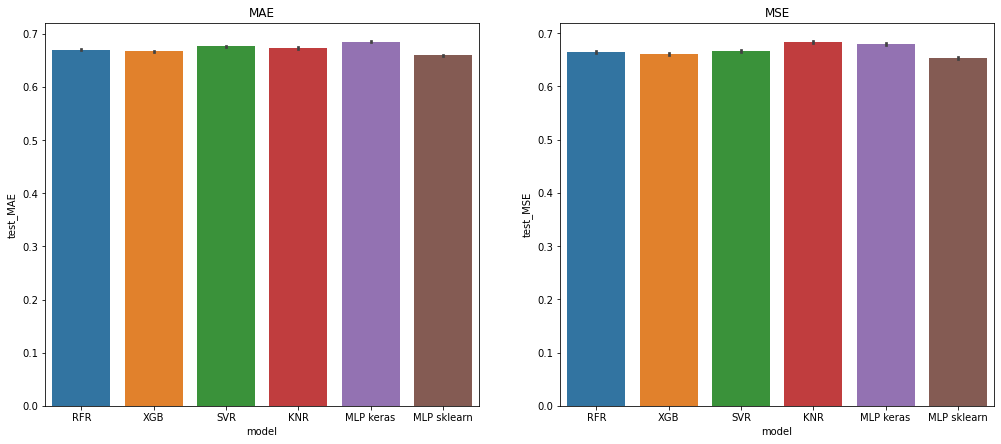

In [430]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.tight_layout(pad=5.0)
sns.barplot(ax=axes[0], data=df_scores, x="model", y="test_MAE")
axes[0].set_title('MAE')
sns.barplot(ax=axes[1], data=df_scores, x="model", y="test_MSE")
axes[1].set_title('MSE')

In [96]:
predict_RFR = return_round_predict(RFR_opt, X_train, y_train, X_test, 3)
predict_XGB = return_round_predict(XGB_opt, X_train, y_train, X_test, 3)
predict_SVR = return_round_predict(SV_opt, X_train, y_train, X_test, 3)
predict_KNR = return_round_predict(KNR_opt, X_train, y_train, X_test, 3)
predict_MLP_s = return_round_predict(MLP_opt, X_train, y_train, X_test, 3)

In [309]:
keras_model = build_model_groups()
keras_model.fit(X_train, y_train, epochs=37, verbose=0, batch_size=32)
predict = keras_model.predict(X_test)
predict_MLP = np.array([round(predict[i][0]) for i in range(len(predict))])

142/142 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'MLP sklearn test')

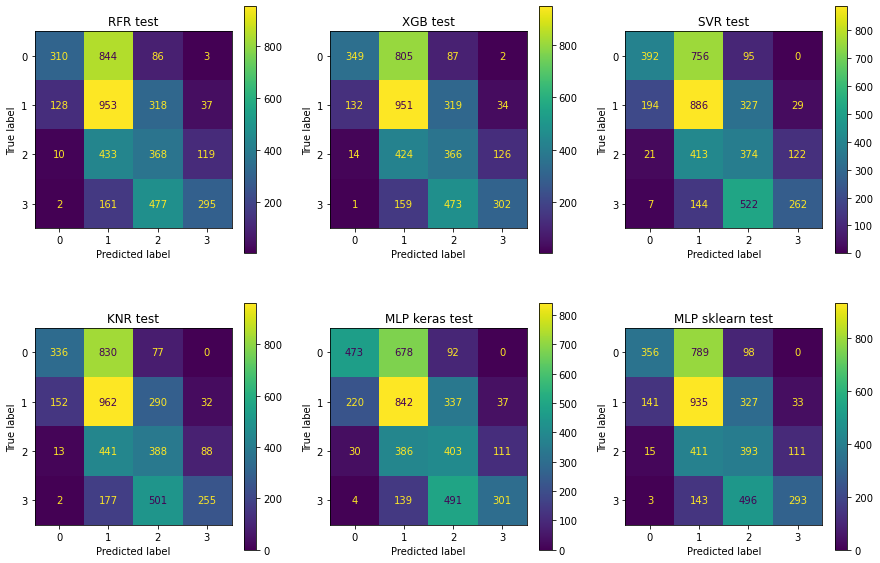

In [423]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
#fig.delaxes(ax[1,2])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_RFR)).plot(ax=ax[0,0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_XGB)).plot(ax=ax[0,1])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_SVR)).plot(ax=ax[0,2])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_KNR)).plot(ax=ax[1,0])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_MLP)).plot(ax=ax[1,1])
ConfusionMatrixDisplay(confusion_matrix(y_test, predict_MLP_s)).plot(ax=ax[1,2])
ax[0,0].set_title("RFR test")
ax[0,1].set_title("XGB test")
ax[0,2].set_title("SVR test")
ax[1,0].set_title("KNR test")
ax[1,1].set_title("MLP keras test")
ax[1,2].set_title("MLP sklearn test")

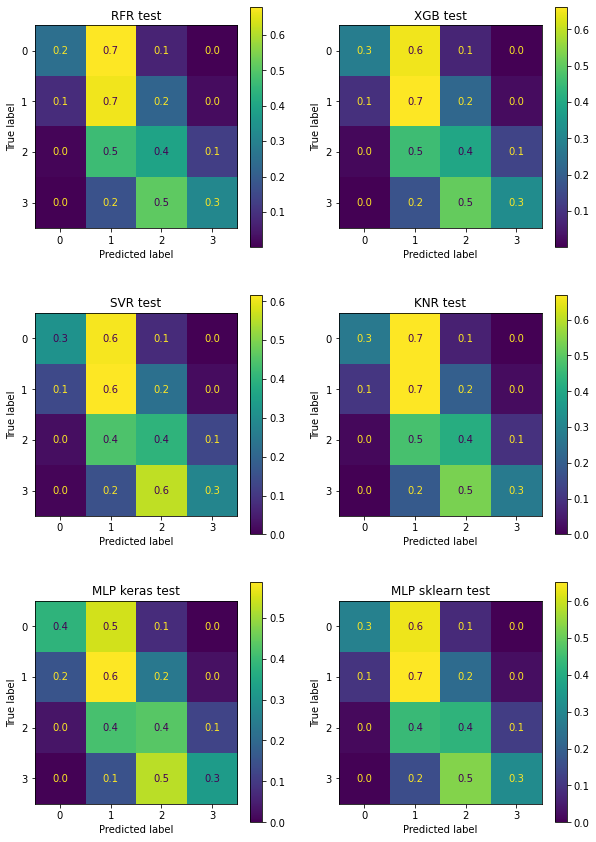

In [428]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
ConfusionMatrixDisplay.from_predictions(y_test, predict_RFR, ax=ax[0,0], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test, predict_XGB, ax=ax[0,1], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test, predict_SVR, ax=ax[1,0], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test, predict_KNR, ax=ax[1,1], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test, predict_MLP, ax=ax[2,0], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test, predict_MLP_s, ax=ax[2,1], normalize = 'true', values_format='.1f')
ax[0,0].set_title("RFR test")
ax[0,1].set_title("XGB test")
ax[1,0].set_title("SVR test")
ax[1,1].set_title("KNR test")
ax[2,0].set_title("MLP keras test")
ax[2,1].set_title("MLP sklearn test")
plt.show()

In [431]:
fig.savefig('group_metrics.png')

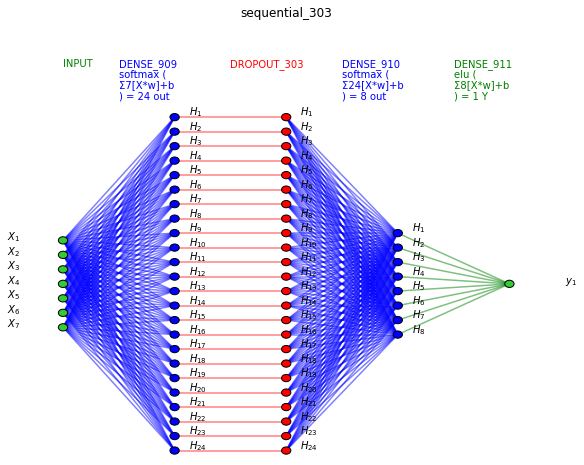

In [311]:
visualize_nn(keras_model, description=True, figsize=(10,8))

## Number of steps prediction

In [313]:
y2 = np.array(df.number_of_steps).ravel()
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y2, test_size=0.25, random_state=1)

In [389]:
def model_builder_steps(hp):
    hp_units = hp.Int('units', min_value=2, max_value=30, step=2)
    hp_units2 = hp.Int('units2', min_value=2, max_value=30, step=2)
    hp_units3 = hp.Int('units3', min_value=2, max_value=30, step=2)
    hp_rate = hp.Choice('rate', values=[0.01, 0.1, 0.2, 0.4, 0.6, 0.8])
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    hp_activation = hp.Choice('activation', values=['sigmoid','relu','softmax','tanh','elu'])
    hp_activation2 = hp.Choice('activation2', values=['sigmoid','relu','softmax','tanh','elu'])
    hp_activation3 = hp.Choice('activation3', values=['sigmoid','relu','softmax','tanh','elu'])
    hp_activation4 = hp.Choice('activation4', values=['sigmoid','relu','softmax','tanh','elu','linear'])
    model = Sequential()
    model.add(Input(x.shape[1]))
    model.add(Dense(units=hp_units, activation=hp_activation))
    model.add(Dense(units=hp_units2, activation=hp_activation2))
    model.add(Dropout(rate=hp_rate))
    model.add(Dense(units=hp_units3, activation=hp_activation3))
    model.add(Dense(1,activation=hp_activation4))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_squared_error', metrics='mae')
    return model

In [391]:
tuner = kt.Hyperband(model_builder_steps, objective='val_loss', max_epochs=100, factor=3,
                     directory='my_dir4', project_name='intro_to_kt')
tuner.search(X_train2, y_train2, epochs=100, validation_split=0.3, callbacks=[stop_early], batch_size=32)
best_hps2 = tuner.get_best_hyperparameters()[0]
print("\nThe hyperparameter search is complete.")
print(f"""The optimal number of 1 units: {best_hps2.get('units')} """)
print(f"""The optimal number of 2 units: {best_hps2.get('units2')} """)
print(f"""The optimal number of 3 units: {best_hps2.get('units3')} """)
print(f"""The optimal number of 1 rate: {best_hps.get('rate')} """)
print(f"""The optimal 1 activation func: {best_hps2.get('activation')}""")
print(f"""The optimal 2 activation func: {best_hps2.get('activation2')}""")
print(f"""The optimal 3 activation func: {best_hps2.get('activation3')}""")
print(f"""The optimal out activation func: {best_hps2.get('activation4')}""")
print(f"""The optimal learning rate: {best_hps2.get('learning_rate')}""")

INFO:tensorflow:Reloading Oracle from existing project my_dir4/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir4/intro_to_kt/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of 1 units: 18 
The optimal number of 2 units: 18 
The optimal number of 3 units: 14 
The optimal number of 1 rate: 0.1 
The optimal 1 activation func: elu
The optimal 2 activation func: softmax
The optimal 3 activation func: sigmoid
The optimal out activation func: elu
The optimal learning rate: 0.01


In [392]:
def build_model_steps():
    model = Sequential()
    model.add(Input(x.shape[1]))
    model.add(Dense(18, activation='elu'))
    model.add(Dense(18, activation='softmax')) 
    model.add(Dropout(rate=0.1))
    model.add(Dense(14, activation='sigmoid'))
    model.add(Dense(1, activation='elu'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics='mae')
    return model

In [393]:
keras_model_steps = build_model_steps()
history = keras_model_steps.fit(X_train2, y_train2, epochs=100, verbose=0, validation_split=0.3, batch_size=32)
loss_per_epoch = history.history['val_loss']
best_epoch = loss_per_epoch.index(min(loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 23


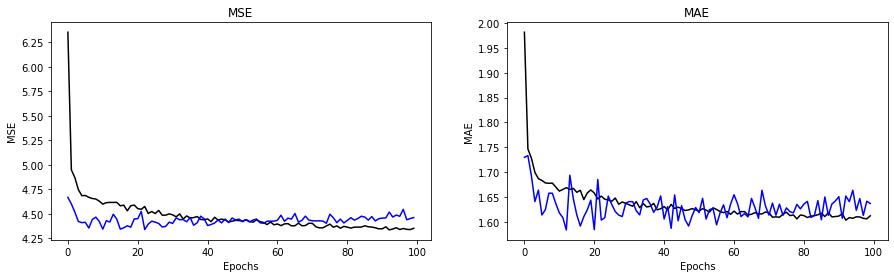

In [394]:
print_metrics(history)

In [395]:
keras_model_steps = build_model_steps()
history = keras_model_steps.fit(X_train2, y_train2, epochs=23, verbose=0, batch_size=32)

In [396]:
evaluate_nn(keras_model_steps, X_train2, y_train2, X_test2, y_test2)

Evaluate
142/142 [==============================] - 0s 2ms/step - loss: 4.5529 - mae: 1.6464

Train data


{'loss': 4.370245456695557, 'mae': 1.6139016151428223}

Test data


{'loss': 4.552915096282959, 'mae': 1.646376371383667}

In [397]:
kFold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True) 
n_repeats=30
scores2 = []
for i in range(n_repeats):
    for train, test in kFold.split(x, y2):
        model = build_model_steps()
        scores2.append(train_evaluate(model, x[train], y2[train], x[test], y2[test]))

57/57 [==============================] - 0s 1ms/step - loss: 4.7947 - mae: 1.6858


57/57 [==============================] - 0s 1ms/step - loss: 4.8200 - mae: 1.7569


57/57 [==============================] - 0s 2ms/step - loss: 4.4008 - mae: 1.6863


57/57 [==============================] - 0s 1ms/step - loss: 4.7733 - mae: 1.6968


In [398]:
d10 = pd.DataFrame.from_dict(scores2)
d10 = d10.rename(columns={0:'test_MSE',1:'test_MAE'})
d10['test_MSE'] = -1*d10['test_MSE']
d10['test_MAE'] = -1*d10['test_MAE']
d10['model']='MLP keras'

In [399]:
d10['test_MSE'].mean() 

-4.6684324741363525

In [237]:
RFR_ste_opt = RandomForestRegressor(random_state=0, max_depth=8, n_estimators=400)
XGB_ste_opt = xgb.XGBRegressor(seed=0, learning_rate=0.1, max_depth=6, n_estimators=30)
SV_ste_opt = SVR(C=1.0, epsilon=1.0) 
KNR_ste_opt = KNeighborsRegressor(algorithm='auto', n_neighbors=50, p=2, weights='distance')
MLP_ste_opt = MLPRegressor(random_state=0, max_iter=1000, hidden_layer_sizes=(12, 12, 20))

In [238]:
score_RFR2 = cross_scoring(RFR_ste_opt, x, y2)
score_XGB2 = cross_scoring(XGB_ste_opt, x, y2)
score_SVR2 = cross_scoring(SV_ste_opt, x, y2)
score_KNR2 = cross_scoring(KNR_ste_opt, x, y2)
score_MLP2_s = cross_scoring(MLP_ste_opt, x, y2)

In [400]:
d6 = pd.DataFrame.from_dict(score_RFR2)
d6['model']='RFR'
d7 = pd.DataFrame.from_dict(score_XGB2)
d7['model']='XGB'
d8 = pd.DataFrame.from_dict(score_SVR2)
d8['model']='SVR'
d9 = pd.DataFrame.from_dict(score_KNR2)
d9['model']='KNR'
d11 = pd.DataFrame.from_dict(score_MLP2_s)
d11['model']='MLP sklearn'

In [401]:
frames = [d6, d7, d8, d9, d10, d11]
df_scores2 = pd.concat(frames)
df_scores2['test_MSE'] = -1*df_scores2['test_MSE']
df_scores2['test_MAE'] = -1*df_scores2['test_MAE']
df_scores2['test_RMSE'] = -1*df_scores2['test_RMSE']

Text(0.5, 1.0, 'MSE')

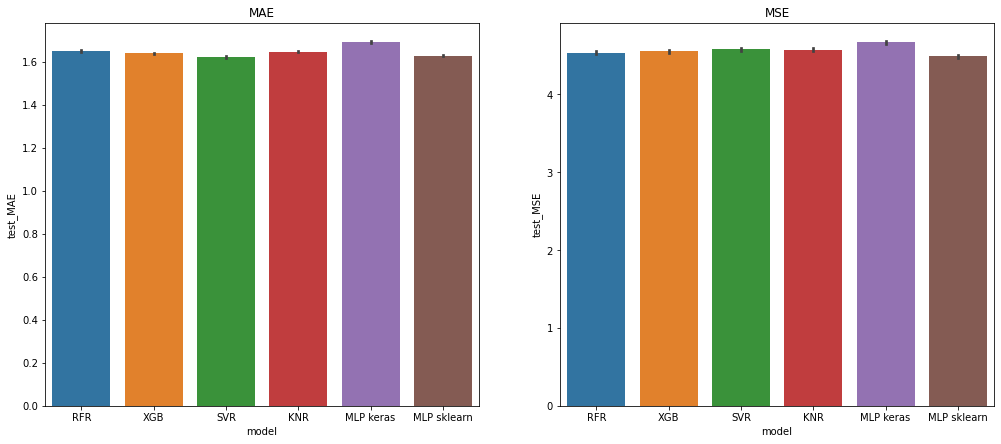

In [432]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.tight_layout(pad=5.0)
sns.barplot(ax=axes[0], data=df_scores2, x="model", y="test_MAE")
axes[0].set_title('MAE')
sns.barplot(ax=axes[1], data=df_scores2, x="model", y="test_MSE")
axes[1].set_title('MSE')

In [160]:
predict_RFR_ste = return_round_predict(RFR_ste_opt, X_train2, y_train2, X_test2, 9)
predict_XGB_ste = return_round_predict(XGB_ste_opt, X_train2, y_train2, X_test2, 9)
predict_SVR_ste = return_round_predict(SV_ste_opt, X_train2, y_train2, X_test2, 9)
predict_KNR_ste = return_round_predict(KNR_ste_opt, X_train2, y_train2, X_test2, 9)
predict_MLP_ste_s = return_round_predict(MLP_ste_opt, X_train2, y_train2, X_test2, 9)

In [404]:
keras_model_steps = build_model_steps()
keras_model_steps.fit(X_train2, y_train2, epochs=23, verbose=0, batch_size=32)
predict_ste = keras_model_steps.predict(X_test2)
predict_MLP_ste = np.array([round(predict_ste[i][0]) for i in range(len(predict_ste))])

142/142 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'MLP sklearn test')

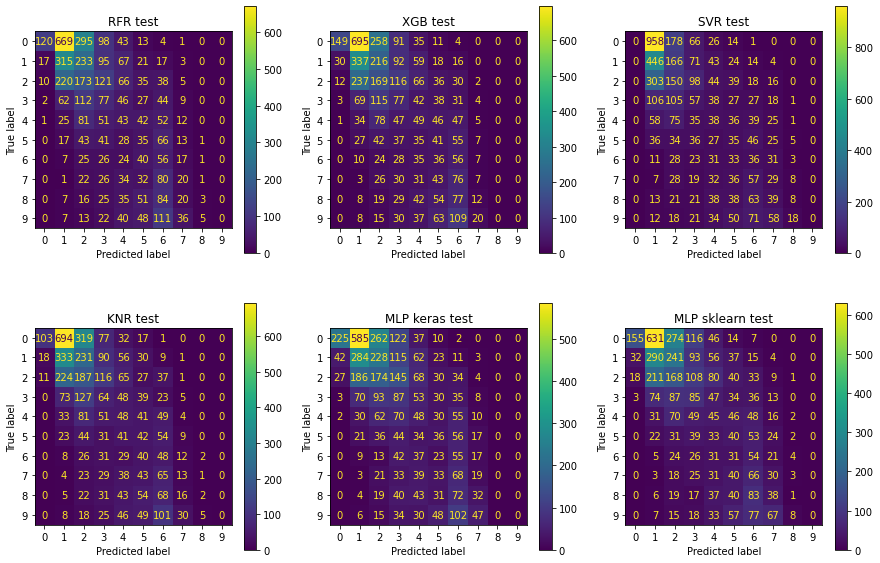

In [405]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
#fig.delaxes(ax[1,2])
ConfusionMatrixDisplay(confusion_matrix(y_test2, predict_RFR_ste)).plot(ax=ax[0,0])
ConfusionMatrixDisplay(confusion_matrix(y_test2, predict_XGB_ste)).plot(ax=ax[0,1])
ConfusionMatrixDisplay(confusion_matrix(y_test2, predict_SVR_ste)).plot(ax=ax[0,2])
ConfusionMatrixDisplay(confusion_matrix(y_test2, predict_KNR_ste)).plot(ax=ax[1,0])
ConfusionMatrixDisplay(confusion_matrix(y_test2, predict_MLP_ste)).plot(ax=ax[1,1])
ConfusionMatrixDisplay(confusion_matrix(y_test2, predict_MLP_ste_s)).plot(ax=ax[1,2])
ax[0,0].set_title("RFR test")
ax[0,1].set_title("XGB test")
ax[0,2].set_title("SVR test")
ax[1,0].set_title("KNR test")
ax[1,1].set_title("MLP keras test")
ax[1,2].set_title("MLP sklearn test")

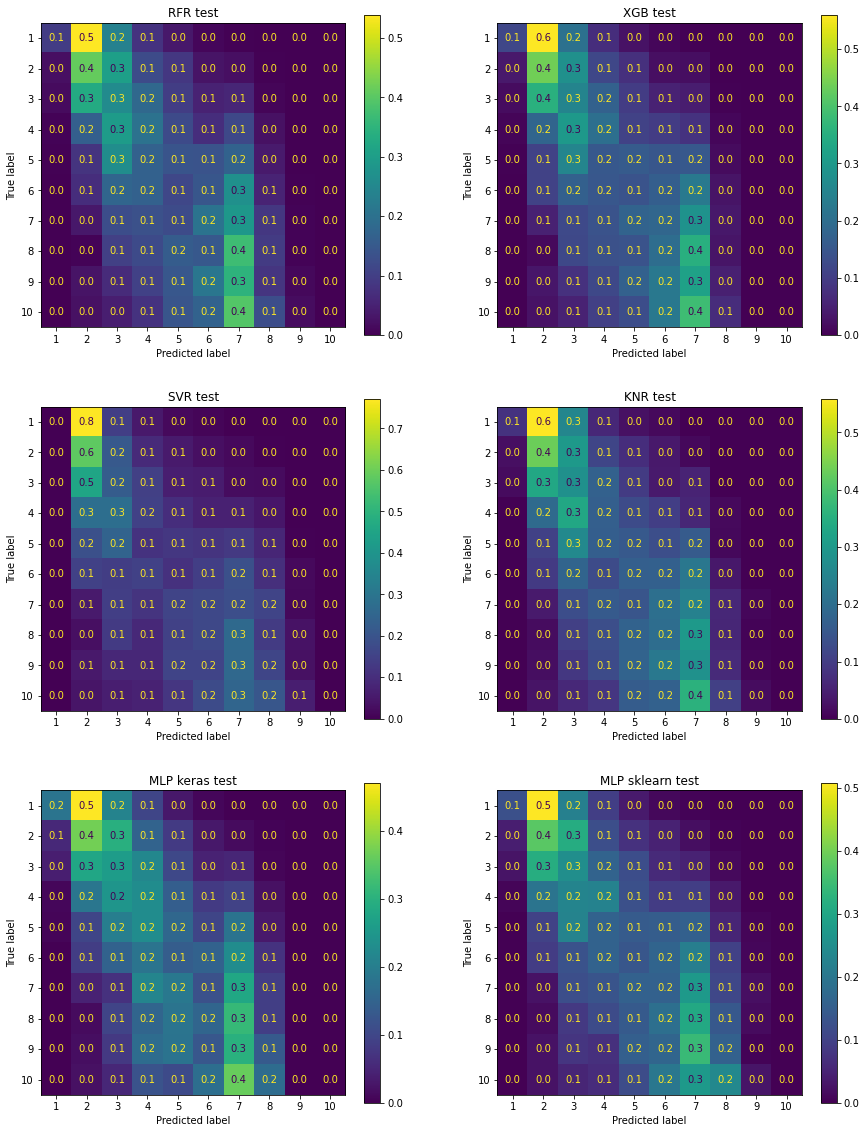

In [421]:
fig, ax = plt.subplots(3, 2, figsize=(15, 20))
ConfusionMatrixDisplay.from_predictions(y_test2, predict_RFR_ste, ax=ax[0,0], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test2, predict_XGB_ste, ax=ax[0,1], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test2, predict_SVR_ste, ax=ax[1,0], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test2, predict_KNR_ste, ax=ax[1,1], normalize = 'true', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(y_test2, predict_MLP_ste, ax=ax[2,0], normalize = 'true', values_format='.1f') #18
ConfusionMatrixDisplay.from_predictions(y_test2, predict_MLP_ste_s, ax=ax[2,1], normalize = 'true', values_format='.1f')

ax[0,0].set_title("RFR test")
ax[0,1].set_title("XGB test")
ax[1,0].set_title("SVR test")
ax[1,1].set_title("KNR test")
ax[2,0].set_title("MLP keras test")
ax[2,1].set_title("MLP sklearn test")
plt.show()

In [433]:
fig.savefig('steps_metrics.png')

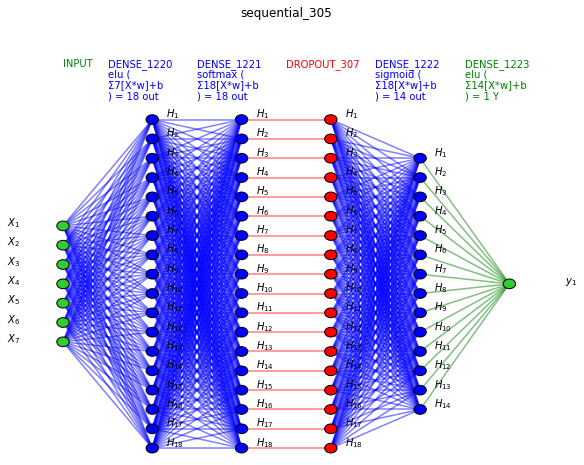

In [409]:
visualize_nn(keras_model_steps, description=True, figsize=(10,8))

# 5. ROC and AUC

Let's see how the groups can be distinguished using the model. We can use ROC and AUC.

In [434]:
import time
import itertools
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [435]:
y = np.array(df.steps_bins).ravel()
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [436]:
def build_model_roc():
    model = Sequential()
    model.add(Input(x.shape[1]))
    #model.add(Dense(20, activation='softmax')) 
    #model.add(Dense(4, activation='linear'))
    model.add(Dense(24, activation='softmax')) 
    model.add(Dropout(rate=0.1))
    model.add(Dense(8, activation='softmax'))  
    model.add(Dense(4, activation='elu'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics='mae')
    return model

In [437]:
keras_model_roc = build_model_roc()
history = keras_model_roc.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.3, batch_size=32)
loss_per_epoch = history.history['val_loss']
best_epoch = loss_per_epoch.index(min(loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 53


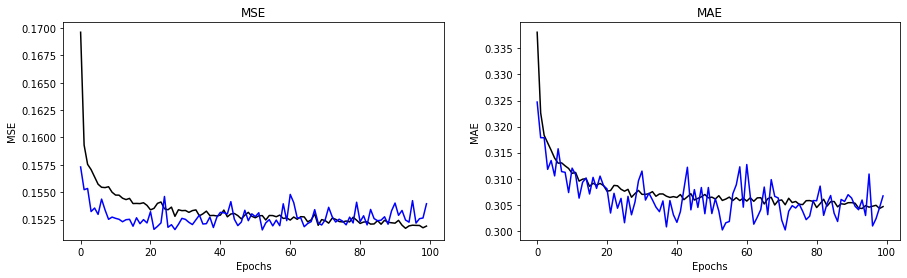

In [438]:
print_metrics(history)

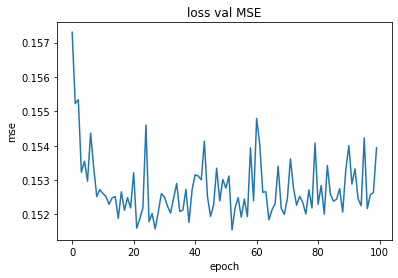

In [439]:
plt.plot(history.history['val_loss'])
plt.title('loss val MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

In [440]:
keras_model_roc = build_model_roc()
history = keras_model_roc.fit(X_train, y_train, epochs=53, verbose=0, batch_size=32)

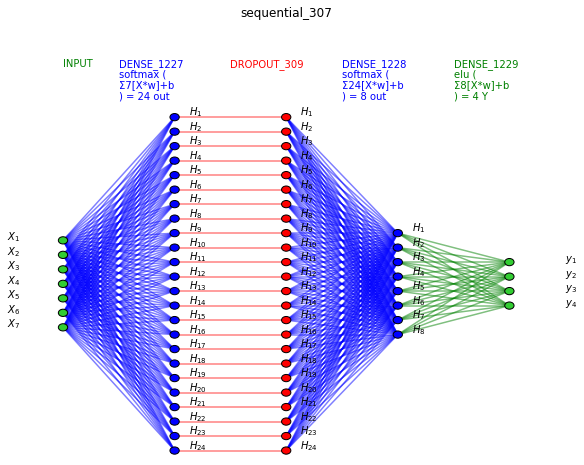

In [441]:
visualize_nn(keras_model_roc, description=True, figsize=(10,8))

In [452]:
evaluate_nn(keras_model_roc, X_train, y_train, X_test, y_test)

Evaluate
142/142 [==============================] - 0s 1ms/step - loss: 0.1566 - mae: 0.3116

Train data


{'loss': 0.15315228700637817, 'mae': 0.3082387447357178}

Test data


{'loss': 0.15662238001823425, 'mae': 0.3116132318973541}

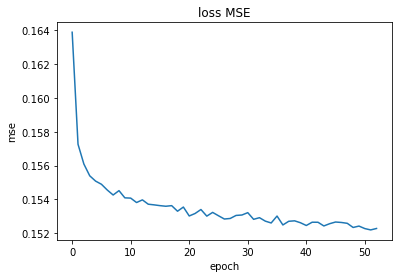

In [443]:
plt.plot(history.history['loss'])
plt.title('loss MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

In [453]:
y_score = keras_model_roc.predict(X_test, batch_size=32)

142/142 [==============================] - 0s 794us/step


- Source of the following code https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [454]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

In [455]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

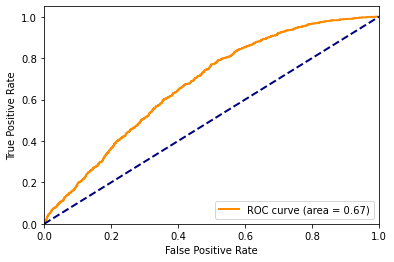

In [456]:
# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [457]:
## Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [458]:
roc_auc

{0: 0.8206393264482842,
 1: 0.6729487748687698,
 2: 0.6718221535334816,
 3: 0.8632897427907261,
 'micro': 0.76192552611554,
 'macro': 0.7573265602233257}

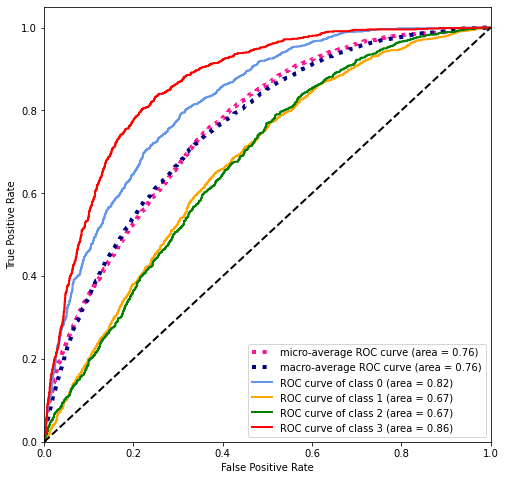

In [459]:
# Plot all ROC curves
plt.figure(figsize = (8,8))
plt.plot(fpr["micro"], tpr["micro"], label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4)

colors = cycle(["cornflowerblue", "orange", "green",'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

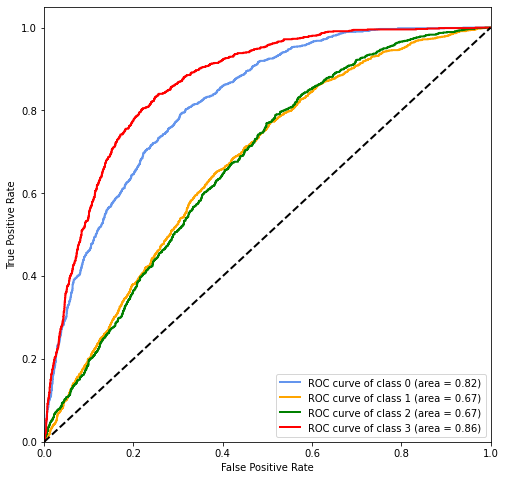

In [460]:
# Plot groups ROC curves
plt.figure(figsize=(8,8))
#colors = cycle(["cornflowerblue", "orange", "green",'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()